In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
content_path =r"C:\Users\hp\Downloads\Python\cont"
style_path = r"C:\Users\hp\Downloads\Python\sty"

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg") :
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize((256,256))
            img = img.convert('RGB')
            img = np.array(img)
            images.append(img)
            img = img / 255.0
    
    images = np.array(images)
    return images

In [4]:
target = load_images_from_folder(content_path)
style = load_images_from_folder(style_path)

In [5]:
from keras.applications.vgg19 import VGG19
model = VGG19(weights = 'imagenet',include_top=False,input_shape=(256,256,3))

In [6]:
model.trainable = False

In [7]:
model_layers=[]
for layer in model.layers:
    model_layers.append(layer.name)
print(model_layers)

model.get_layer('block5_conv4').output

['input_layer', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


<KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, name=keras_tensor_20>

In [8]:
style_layers= [('block1_conv1',0.2),('block2_conv1',0.2),('block3_conv1',0.2), ('block4_conv1',0.2),('block5_conv1',0.2)]

In [9]:
def content_cost(content_image_model_output, generated_image_model_output):
    a_content= content_image_model_output[-1]
    a_generated= generated_image_model_output[-1]
    m,n_H,n_W,n_C= a_generated.get_shape().as_list()
    a_content_unrolled = tf.reshape(a_content,[m,-1,n_C])
    a_generated_unrolled = tf.reshape(a_generated,[m,-1,n_C])
    J_content= (1/(4*n_H*n_W*n_C))* tf.reduce_sum(tf.square(tf.subtract(a_content_unrolled,a_generated_unrolled)))
    return J_content

In [10]:
def gram_matrix(M):
    Gram_matrix= tf.matmul(M, tf.transpose(M))
    return Gram_matrix

In [11]:
def one_layer_style_cost(a_style_layer, a_generated_layer):
    m, n_H, n_W, n_C= a_generated_layer.get_shape().as_list()
    a_style_layer= tf.transpose(tf.reshape(a_style_layer,[-1,n_C]),[1,0])
    a_generated_layer= tf.transpose(tf.reshape(a_generated_layer,[-1,n_C]), [1,0])
    gram_style = gram_matrix(a_style_layer)
    gram_gen= gram_matrix(a_generated_layer)
    J_style_layer= (1/(4*n_C**2*(n_H*n_W)**2))*tf.reduce_sum(tf.square(tf.subtract(gram_style,gram_gen)))
    return J_style_layer

In [12]:
def style_cost(style_image_model_output, generated_image_model_output, style_layers= style_layers):
    J_style= 0
    style_activations= style_image_model_output[1:]
    generated_activations= generated_image_model_output[1:]
    num_layers = len(style_activations)
    
    for i, tuple_name_weight in zip(range(num_layers), style_layers):
        style_cost_layer= one_layer_style_cost(style_activations[i],generated_activations[i])
        style_cost_layer *= tuple_name_weight[1]
        J_style += style_cost_layer
    return J_style

In [13]:
def total_cost(J_content,J_style,alpha=10, beta=40):
    J_total= alpha* J_content + beta* J_style
    return J_total

In [14]:
def mini_vgg19(layers):
    model = VGG19(include_top=False, weights='imagenet')
    mini_model_outputs = [model.get_layer(layer_weight[0]).output for layer_weight in layers]
    
    mini_model = tf.keras.Model(inputs=model.input, outputs=mini_model_outputs)
    return mini_model

In [15]:
s_image = style[0]

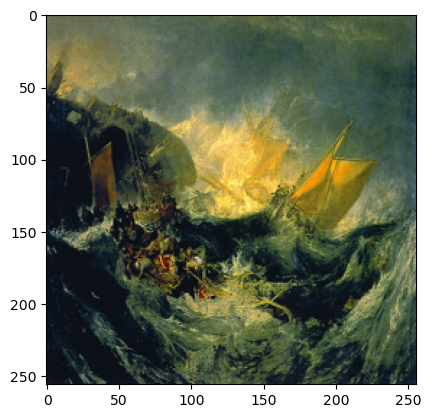

In [16]:
style_image_arr= np.array(s_image)
plt.imshow(style_image_arr)

In [17]:
arr_style_image =tf.image.random_crop(style_image_arr,[256,256, 3]) 
style_image= tf.constant(np.reshape(arr_style_image.numpy(),(1,)+(256,256,3)))
print(style_image.shape)

(1, 256, 256, 3)


In [18]:
t_image = target[0]

(1, 256, 256, 3)


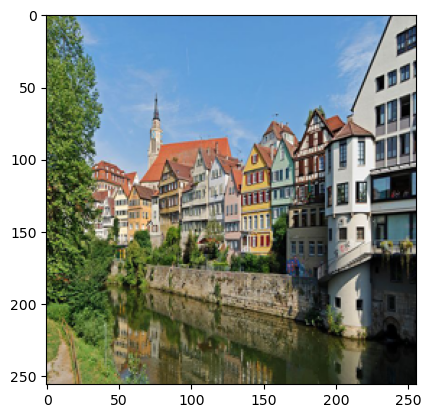

In [19]:
content_image_arr= np.array(t_image)
content_image_arr_reshaped= np.reshape(content_image_arr, ((1,)+ content_image_arr.shape))
print(content_image_arr_reshaped.shape)
content_image= tf.constant(content_image_arr_reshaped)
plt.imshow(content_image_arr)

In [20]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

In [21]:
content_layer= [('block5_conv4',1)]
mini_vgg19_model= mini_vgg19(style_layers+ content_layer)

In [22]:
content_image= tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
style_image= tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))

C_list_vgg19_encoders= mini_vgg19_model(content_image)
S_list_vgg19_encoders= mini_vgg19_model(style_image)
G_list_vgg19_encoders= mini_vgg19_model(generated_image)

In [23]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [24]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

In [25]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [26]:
def train_step_one(image, loss_history):
    with tf.GradientTape() as tape:
        aciv_G = mini_vgg19_model(image)
        J_content = content_cost(C_list_vgg19_encoders, aciv_G)
        J_style = style_cost(S_list_vgg19_encoders, aciv_G, style_layers)
        J_total = total_cost(J_content, J_style)
        loss_history.append(J_total.numpy())
   
    grad = tape.gradient(J_total, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [27]:
import time

start = time.time()
epochs = 40
steps_per_epoch = 100
step = 0
loss_history = []

for i in range(epochs):
    for j in range(steps_per_epoch):
        step += 1
        train_step_one(generated_image, loss_history)

print("Train step: {}".format(step))
image = tensor_to_image(generated_image)
end = time.time()
print("Total time: {:.1f}".format(end - start))

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('Total Loss')
plt.title('Loss During Training')
plt.show()

In [ ]:
image